In [1]:
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Read in results data from seasons 13/14 to the test season 23/24

data1 = pd.read_csv('/content/drive/MyDrive/2013-14.csv')
data2 = pd.read_csv('/content/drive/MyDrive/2014-15.csv')
data3 = pd.read_csv('/content/drive/MyDrive/2015-16.csv')
data4 = pd.read_csv('/content/drive/MyDrive/2016-17.csv')
data5 = pd.read_csv('/content/drive/MyDrive/2017-18.csv')
data6 = pd.read_csv('/content/drive/MyDrive/2018-19.csv')
data7 = pd.read_csv('/content/drive/MyDrive/2019-20.csv')
data8 = pd.read_csv('/content/drive/MyDrive/2020-2021.csv')
data9 = pd.read_csv('/content/drive/MyDrive/2021-2022.csv')
data10 = pd.read_csv('/content/drive/MyDrive/22-23.csv')


data11 = pd.read_csv('/content/drive/MyDrive/23-24.csv')





#data12 = pd.read_csv('/content/drive/MyDrive/24-25.csv')
# Need to compare to just using last seasons points tallies

In [4]:
# select relevant columns only
# NB there are stats disregarded here that could be used as prior information going into the following season, i.e. if a team has been very unlucky the underlying stats
# could show this

df1 = data1[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df2 = data2[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df3 = data3[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df4 = data4[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df5 = data5[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df6 = data6[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df7 = data7[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df8 = data8[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df9 = data9[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df10 = data10[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
test = data11[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]

#df12 = data12[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]

# merge only the train data sets i.e. leave out 23/24 season

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])
len(df)

3460

In [5]:
df['HomeTeam'].unique()

array(['Arsenal', 'Liverpool', 'Norwich', 'Sunderland', 'Swansea',
       'West Brom', 'West Ham', 'Chelsea', 'Crystal Palace', 'Man City',
       'Aston Villa', 'Everton', 'Fulham', 'Hull', 'Newcastle',
       'Southampton', 'Stoke', 'Cardiff', 'Tottenham', 'Man United',
       'Leicester', 'QPR', 'Burnley', 'Bournemouth', 'Watford',
       'Middlesbrough', 'Brighton', 'Huddersfield', 'Wolves',
       'Sheffield United', 'Leeds', 'Brentford', "Nott'm Forest"],
      dtype=object)

In [6]:
# get the promoted teams (in df1)

def promoted_teams(df1, df2):
  return(np.setdiff1d(df1['HomeTeam'].unique(), df2['HomeTeam'].unique()))

In [7]:
promoted_teams = promoted_teams(test,df10)

In [8]:
#promoted teams for test season
promoted_teams

array(['Burnley', 'Luton', 'Sheffield United'], dtype=object)

In [9]:
def get_team_names(val):
 ''' Get the team_names for val or test set inputted so that the first 20 are the teams in the season used for performance measure'''
 teams_in_val = pd.unique(val[['HomeTeam', 'AwayTeam']].values.ravel('K'))
 teams_in_df = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K'))
 teams_not_in_val = np.setdiff1d(teams_in_df, teams_in_val)
 new_team_names = np.concatenate((teams_in_val, teams_not_in_val))
 return(list(new_team_names))

In [10]:
team_names = get_team_names(test)

In [11]:
# net transfer money spent (millions) in the period of the data

team_balances = {
    'Arsenal': -353.61,
    'Liverpool': -172.00,
    'Burnley': -18.77,
    'Sheffield United': -15.44,
    'West Ham': -245.00,
    'Chelsea': -787.19,
    'Crystal Palace': -100.15,
    'Man City': -214.93,
    'Aston Villa': -94.37,
    'Everton': 96.78,
    'Fulham': -93.42,
    'Newcastle': -253.09,
    'Luton': -34.77,
    'Tottenham': -422.60,
    'Man United': -495.66,
    'Bournemouth': -280.31,
    'Brighton': -66.61,
    'Wolves': -47.64,
    'Brentford': -131.65,
    "Nott'm Forest": -260.96,
    'Leeds': 78.77,
    'Norwich': 0,
    'Swansea': 0,
    'Hull': 0,
    'Stoke': 0,
    'Cardiff': 0,
    'Sunderland': 0,
    'QPR': 0,
    'Leicester': 49.10,
    'Watford': 0,
    'Ipswich': -157.80,
    'Southampton': -63.58,
    'Middlesbrough': 0,
    'Huddersfield': 0,
    'West Brom': 0
}

In [12]:
# convert to numerical values 0 = Arsenal etc.

df.loc[:, 'home_id'] = pd.Categorical(df['HomeTeam'], categories=team_names).codes
df.loc[:, 'away_id'] = pd.Categorical(df['AwayTeam'], categories=team_names).codes

In [13]:
df

,HomeTeam,AwayTeam,FTHG,FTAG,home_id,away_id
0,Arsenal,Aston Villa,1,3,1,16
1,Liverpool,Stoke,1,0,12,29
2,Norwich,Everton,2,2,26,4
3,Sunderland,Fulham,0,1,30,11
4,Swansea,Man United,1,4,31,9
...,...,...,...,...,...,...
375,Everton,Bournemouth,1,0,4,2
376,Leeds,Tottenham,1,4,23,14
377,Leicester,West Ham,2,1,24,17
378,Man United,Fulham,2,1,9,11


In [14]:
# decay rate could be changed?? put into a pipeline then run with 5 values.

match_time = np.arange(len(df))
decay_rate = 0.001
w = np.exp(- decay_rate * (match_time.max() - match_time))
w = w / np.mean(w)

In [15]:
# transform balances to range (0,1), maybe experiment with this transformation

balances_list = list(team_balances.values())

scaled_team_balances_dict = {}
# Use the team_balances dictionary to calculate and store scaled balances
for team, balance in team_balances.items():
    scaled_balance = (balance - np.min(balances_list)) / (np.max(balances_list) - np.min(balances_list))
    scaled_team_balances_dict[team] = scaled_balance

# Create the scaled_balances_ordered array in the same order as the current team_names list
scaled_balances_ordered = np.array([scaled_team_balances_dict.get(team, None) for team in team_names])


In [16]:
scaled_balances_ordered

array([0.86928289, 0.49049176, 0.57341312, 0.81516341, 1.        ,
       0.87304999, 0.60420603, 0.74158625, 0.        , 0.32979626,
       0.59530301, 0.78483433, 0.69593991, 0.83662341, 0.41244612,
       0.64737491, 0.78375963, 0.61335792, 0.77722095, 0.85118273,
       0.89051665, 0.89051665, 0.89051665, 0.97962601, 0.94606152,
       0.89051665, 0.89051665, 0.89051665, 0.81859113, 0.89051665,
       0.89051665, 0.89051665, 0.89051665, 0.89051665])

In [17]:
#pymc model
#NOTE! Alpha and beta variables are a and b from dissertation, changed in write up for clarity.


with pm.Model() as model_weighted:
    alphas_raw = pm.Gamma("alphas_raw", alpha=2.5, beta=0.7, shape=len(team_names))
    alphas = pm.Deterministic("alphas", alphas_raw / pt.mean(alphas_raw))
    betas_raw = pm.Gamma("betas_raw", alpha=2.2, beta=0.7, shape=len(team_names))
    betas = pm.Deterministic("betas", betas_raw / pt.mean(betas_raw))
    gamma = pm.LogNormal("gamma", 0.2, 0.4)


    lambda_h = alphas[df.home_id.values] * betas[df.away_id.values] * gamma
    lambda_a = alphas[df.away_id.values] * betas[df.home_id.values]

    logp_home = pm.logp(pm.Poisson.dist(mu=lambda_h), df["FTHG"].values)
    logp_away = pm.logp(pm.Poisson.dist(mu=lambda_a), df["FTAG"].values)

    weighted_logp = (logp_home + logp_away) * w

    pm.Potential("weighted_likelihood", weighted_logp.sum())

    trace_w = pm.sample(10000, tune=1000, step=pm.NUTS(), return_inferencedata=False)


Output()

In [18]:
alpha_samples_w = trace_w['alphas']
beta_samples_w = trace_w['betas']
gamma_samples_w = trace_w['gamma']

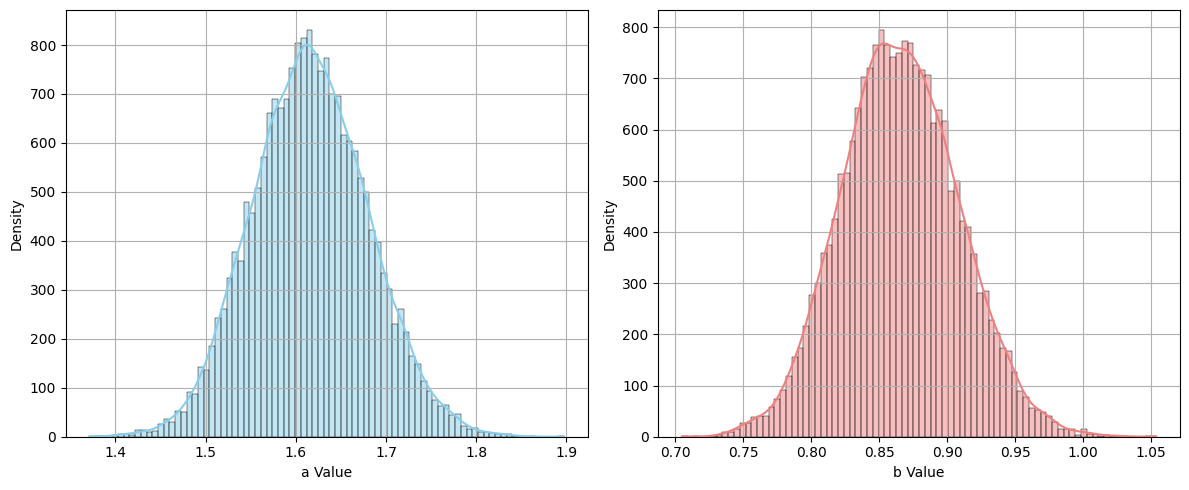

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Find the index for Arsenal in the team_names list
arsenal_index = team_names.index('Arsenal')

# Extract posterior samples for Arsenal's alpha and beta
arsenal_as = trace_w['alphas'][:, arsenal_index]
arsenal_bs = trace_w['betas'][:, arsenal_index]

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for Arsenal's a (Attack)
sns.histplot(arsenal_as, ax=axes[0], kde=True, color='skyblue')

axes[0].set_xlabel("a Value")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Histogram for Arsenal's b (Defense)
sns.histplot(arsenal_bs, ax=axes[1], kde=True, color='lightcoral')

axes[1].set_xlabel("b Value")
axes[1].set_ylabel("Density")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import itertools

def build_fixtures(team_indices):
    # Double round robin: each team plays every other team twice
    fixtures = []
    for home, away in itertools.permutations(team_indices, 2):
        if home < away:
            fixtures.append((home, away))  # home match
            fixtures.append((away, home))  # reverse fixture
    return fixtures

def simulate_match_points(i, j, alpha_samples, beta_samples, gamma_samples, promoted_teams, r, k, scaled_balances_ordered):
    # Pick a random posterior sample
    idx = np.random.randint(alpha_samples.shape[0])
    # Ensure scalar values are used for parameters
    alpha_i = alpha_samples[idx, i] - k*scaled_balances_ordered[i]
    beta_j = beta_samples[idx, j] + k*scaled_balances_ordered[j]
    alpha_j = alpha_samples[idx, j] - k*scaled_balances_ordered[j] # Corrected index for alpha_j
    beta_i = beta_samples[idx, i] + k*scaled_balances_ordered[i] # Corrected index for beta_i
    gamma  = gamma_samples[idx]


    # Apply penalty/bonus for promoted teams
    if team_names[i] in promoted_teams:
        alpha_i = max(0.01, alpha_i - r)
        beta_i = beta_i + r
    if team_names[j] in promoted_teams:
        alpha_j = max(0.01, alpha_j - r) # Apply penalty/bonus to away team's attack/defense
        beta_j = beta_j + r


    # Simulate goals - ensure scalar lambda values
    lambda_h = max(0.01, alpha_i * beta_j * gamma) # Ensure lambda is not zero or negative
    lambda_a = max(0.01, alpha_j * beta_i) # Ensure lambda is not zero or negative

    hg = np.random.poisson(lambda_h) # Simulate a single home goal count
    ag = np.random.poisson(lambda_a) # Simulate a single away goal count


    # Convert to points - now hg and ag are scalar
    if hg > ag:
        return 3, 0  # home win
    elif hg < ag:
        return 0, 3  # away win
    else:
        return 1, 1  # draw


def simulate_season_points(fixtures, alpha_samples, beta_samples, gamma_samples, n_teams):
    points = np.zeros(n_teams, dtype=int)
    for home, away in fixtures:
        ph, pa = simulate_match_points(home, away, alpha_samples, beta_samples, gamma_samples, promoted_teams, 0.3, 0.05, scaled_balances_ordered)
        points[home] += ph
        points[away] += pa
    return points

league_indices = list(range(20))  # first 20 teams
fixtures = build_fixtures(league_indices)

season_points = simulate_season_points(
    fixtures,
    alpha_samples_w,
    beta_samples_w,
    gamma_samples_w,
    n_teams=20
)

points_df = pd.DataFrame({
    "Team": [team_names[i] for i in league_indices],
    "Points": season_points.astype(int)
}).sort_values(by="Points", ascending=False).reset_index(drop=True)

print(points_df)

                Team  Points
0          Liverpool      89
1           Man City      83
2            Arsenal      75
3            Chelsea      71
4          Tottenham      70
5         Man United      70
6          Newcastle      63
7           West Ham      55
8          Brentford      54
9            Everton      50
10            Fulham      49
11       Aston Villa      49
12          Brighton      46
13    Crystal Palace      44
14       Bournemouth      39
15     Nott'm Forest      38
16           Burnley      36
17            Wolves      30
18             Luton      21
19  Sheffield United      19


In [21]:
# Calculate points for each match
def calculate_points(home_goals, away_goals):
    if home_goals > away_goals:
        return 3, 0  # Home win
    elif home_goals == away_goals:
        return 1, 1  # Draw
    else:
        return 0, 3  # Away win


def get_league_table(season):
# Apply the function to the 2022-2023 data (df12)
 season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')

# Aggregate points by team
 team_points = {}
 for index, row in season.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_pts = row['HomePts']
    away_pts = row['AwayPts']

    if home_team not in team_points:
        team_points[home_team] = 0
    if away_team not in team_points:
        team_points[away_team] = 0

    team_points[home_team] += home_pts
    team_points[away_team] += away_pts

# Sort teams by points
 sorted_team_points = sorted(team_points.items(), key=lambda item: item[1], reverse=True)

 # Keep the list of just points for potential later use if needed
 return(team_points)

In [22]:
# actual 23/24 league table

get_league_table(test)

/tmp/ipython-input-4214960507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')
/tmp/ipython-input-4214960507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')


{'Burnley': 24,
 'Man City': 91,
 'Arsenal': 89,
 "Nott'm Forest": 36,
 'Bournemouth': 48,
 'West Ham': 52,
 'Brighton': 48,
 'Luton': 26,
 'Everton': 48,
 'Fulham': 47,
 'Sheffield United': 16,
 'Crystal Palace': 49,
 'Newcastle': 60,
 'Aston Villa': 68,
 'Brentford': 39,
 'Tottenham': 66,
 'Chelsea': 63,
 'Liverpool': 82,
 'Man United': 60,
 'Wolves': 46}

In [23]:
def simulate_multiple_seasons(N, team_indices, alpha_samples, beta_samples, gamma_samples, team_names):
    fixtures = build_fixtures(team_indices)
    all_points = np.zeros((N, len(team_indices)), dtype=float)

    for sim in range(N):
        season_points = simulate_season_points(fixtures, alpha_samples, beta_samples, gamma_samples, len(team_indices))
        all_points[sim, :] = season_points

    avg_points = all_points.mean(axis=0)

    points_df = pd.DataFrame({
        "Team": [team_names[i] for i in team_indices],
        "Avg Points": avg_points.round(2)
    }).sort_values(by="Avg Points", ascending=False).reset_index(drop=True)

    return points_df


league_indices = list(range(20))  # first 20 teams
avg_points_df = np.round(simulate_multiple_seasons(
    N=1000,
    team_indices=league_indices,
    alpha_samples=alpha_samples_w,
    beta_samples=beta_samples_w,
    gamma_samples=gamma_samples_w,
    team_names=team_names
),0)



# final prediction of league table
print(avg_points_df)

                Team  Avg Points
0           Man City        87.0
1          Liverpool        78.0
2            Arsenal        71.0
3          Tottenham        68.0
4            Chelsea        67.0
5         Man United        65.0
6          Brentford        57.0
7           Brighton        56.0
8          Newcastle        56.0
9        Aston Villa        53.0
10          West Ham        53.0
11            Fulham        48.0
12    Crystal Palace        48.0
13           Everton        45.0
14            Wolves        44.0
15       Bournemouth        41.0
16     Nott'm Forest        40.0
17           Burnley        24.0
18             Luton        22.0
19  Sheffield United        17.0


In [24]:
def calculate_mse(sim_df, actual_points_dict):
    # Map simulated points to a dictionary
    sim_points_dict = dict(zip(sim_df["Team"], sim_df["Avg Points"]))

    # Make sure we only compare teams in both sets
    common_teams = set(sim_points_dict.keys()) & set(actual_points_dict.keys())

    # Extract aligned arrays
    sim_points = np.array([sim_points_dict[team] for team in common_teams])
    actual_points = np.array([actual_points_dict[team] for team in common_teams])

    # Mean Squared Error
    mse = np.mean((sim_points - actual_points) ** 2)
    return mse

In [25]:
# mse for prediction

calculate_mse(avg_points_df, get_league_table(test))

/tmp/ipython-input-4214960507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')


np.float64(56.4)

In [26]:
import arviz as az

# Assuming alpha_samples_w and beta_samples_w are already extracted as NumPy arrays
# e.g., alpha_samples_w = trace_w['alphas']

# Calculate the mean (MAP estimate approximation) and 95% HDI for each team's alpha and beta samples
alpha_map = np.mean(alpha_samples_w, axis=0)
alpha_hdi = az.hdi(alpha_samples_w, hdi_prob=0.95)

beta_map = np.mean(beta_samples_w, axis=0)
beta_hdi = az.hdi(beta_samples_w, hdi_prob=0.95)

# Create a DataFrame to display the results
# Ensure team_names is correctly ordered and matches the order of the samples
results_df = pd.DataFrame({
    'Team': team_names,
    'Alpha (Attack) MAP': alpha_map,
    'Alpha (Attack) 95% CI': [f"[{hdi[0]:.2f}, {hdi[1]:.2f}]" for hdi in alpha_hdi],
    'Beta (Defense) MAP': beta_map,
    'Beta (Defense) 95% CI': [f"[{hdi[0]:.2f}, {hdi[1]:.2f}]" for hdi in beta_hdi]
})

# Display the table
display(results_df)

/tmp/ipython-input-1842736947.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  alpha_hdi = az.hdi(alpha_samples_w, hdi_prob=0.95)
/tmp/ipython-input-1842736947.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  beta_hdi = az.hdi(beta_samples_w, hdi_prob=0.95)


,Team,Alpha (Attack) MAP,Alpha (Attack) 95% CI,Beta (Defense) MAP,Beta (Defense) 95% CI
0,Burnley,0.805610,"[0.70, 0.92]",1.016379,"[0.90, 1.13]"
1,Arsenal,1.616220,"[1.49, 1.74]",0.865548,"[0.78, 0.95]"
2,Bournemouth,0.938510,"[0.82, 1.06]",1.243790,"[1.11, 1.37]"
3,Brighton,1.200483,"[1.09, 1.31]",0.938881,"[0.84, 1.03]"
4,Everton,0.991752,"[0.89, 1.09]",1.056951,"[0.96, 1.15]"
5,Sheffield United,0.592998,"[0.45, 0.75]",0.945579,"[0.78, 1.12]"
6,Newcastle,1.165793,"[1.06, 1.28]",0.945382,"[0.85, 1.04]"
7,Brentford,1.201569,"[1.06, 1.35]",0.901709,"[0.79, 1.02]"
8,Chelsea,1.305552,"[1.19, 1.42]",0.778214,"[0.70, 0.86]"
9,Man United,1.357645,"[1.24, 1.47]",0.850090,"[0.77, 0.93]"


<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4186313841.py:26: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(x_gamma, y_gamma, label='$\psi$ Prior (LogNormal(0.2, 0.4))', color='green')


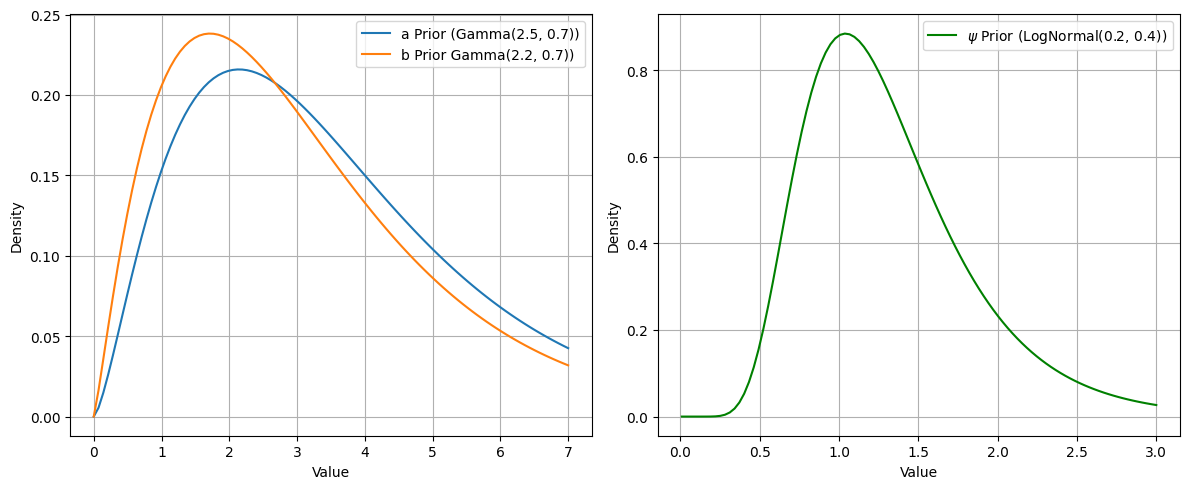

In [27]:
from scipy.stats import gamma, lognorm

# Plot the prior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gamma prior for alphas (alpha=3, beta=1/0.6) - Increased spread by increasing scale
x_alpha = np.linspace(0, 7, 100) # Extend the x-axis further
y_alpha = gamma.pdf(x_alpha, a=2.5, scale=1/(0.7)) # Increased scale from 0.6 to 1.0 (beta from 1/0.6 to 1/1.0)
axes[0].plot(x_alpha, y_alpha, label='a Prior (Gamma(2.5, 0.7))')

# Gamma prior for betas (alpha=2.5, beta=1/0.5) - Increased spread by increasing scale
x_beta = np.linspace(0, 7, 100) # Extend the x-axis further
y_beta = gamma.pdf(x_beta, a=2.2, scale=1/(0.7))# Increased scale from 0.5 to 0.8 (beta from 1/0.5 to 1/0.8)
axes[0].plot(x_beta, y_beta, label='b Prior Gamma(2.2, 0.7))')

#axes[0].set_title('Prior Distributions for a and b')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)


# LogNormal prior for gamma (mu=0.2, sigma=0.4) - Keep this the same
x_gamma = np.linspace(0.01, 3, 100)
y_gamma = lognorm.pdf(x_gamma, s=0.4, scale=np.exp(0.2))
axes[1].plot(x_gamma, y_gamma, label='$\psi$ Prior (LogNormal(0.2, 0.4))', color='green')

#axes[1].set_title('Prior Distribution for Psi')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()

In [29]:
# arbitrary performance measure using last years final tallies

# get league tables for both seasons
league_table_df10 = get_league_table(df10)
league_table_val = get_league_table(test)

# Convert dictionaries to pandas Series for easier handling and alignment
points_df10 = pd.Series(league_table_df10)
points_val = pd.Series(league_table_val)

# Find common teams
common_teams = list(set(points_df10.index) & set(points_val.index))

# Filter points for common teams
common_points_df10 = points_df10.loc[common_teams]
common_points_val = points_val.loc[common_teams]

# team alignment
common_points_val_aligned = common_points_val.reindex(common_points_df10.index)

# Calculate Mean Squared Error for common teamsn
mse = np.mean((common_points_df10.values - common_points_val_aligned.values) ** 2)

print(f"Number of common teams: {len(common_teams)}")
print(f"MSE between 2022-2023 and 2023-2024 season points for common teams: {mse}")

Number of common teams: 17
MSE between 2022-2023 and 2023-2024 season points for common teams: 122.41176470588235


/tmp/ipython-input-4214960507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')
/tmp/ipython-input-4214960507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season[['HomePts', 'AwayPts']] = season.apply(lambda row: calculate_points(row['FTHG'], row['FTAG']), axis=1, result_type='expand')


/tmp/ipython-input-30454407.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipython-input-30454407.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


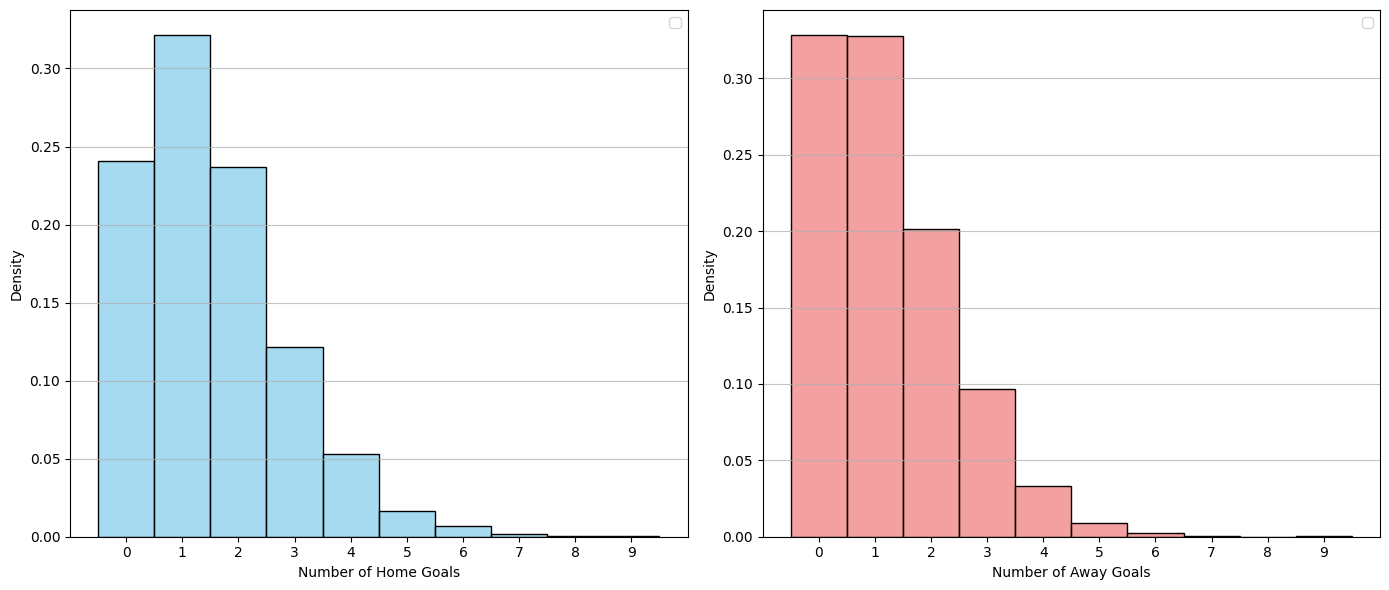

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import numpy as np

# Calculate the mean number of home and away goals
mean_home_goals = df['FTHG'].mean()
mean_away_goals = df['FTAG'].mean()

# Define the range of goals to plot the PMF for
max_goals = max(df['FTHG'].max(), df['FTAG'].max())
goal_range = np.arange(0, max_goals + 1)

# Calculate the Poisson PMF for home and away goals
poisson_home_pmf = poisson.pmf(goal_range, mean_home_goals)
poisson_away_pmf = poisson.pmf(goal_range, mean_away_goals)

# Plotting histograms with overlaid Poisson PMF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for Full Time Home Goals (FTHG)
sns.histplot(df['FTHG'], ax=axes[0], bins=range(0, max_goals + 2), discrete=True, color='skyblue', stat='density')
#axes[0].plot(goal_range, poisson_home_pmf, 'ro-', markersize=5, label=f'Poisson PMF (λ={mean_home_goals:.2f})')
#axes[0].set_title('Distribution of Full Time Home Goals (FTHG) with Poisson PMF')
axes[0].set_xlabel('Number of Home Goals')
axes[0].set_ylabel('Density') # Changed to Density to match PMF scale
axes[0].set_xticks(range(0, max_goals + 1)) # Ensure integer ticks
axes[0].legend()
axes[0].grid(axis='y', alpha=0.75)

# Histogram for Full Time Away Goals (FTAG)
sns.histplot(df['FTAG'], ax=axes[1], bins=range(0, max_goals + 2), discrete=True, color='lightcoral', stat='density')
##axes[1].plot(goal_range, poisson_away_pmf, 'bo-', markersize=5, label=f'Poisson PMF (λ={mean_away_goals:.2f})')
#axes[1].set_title('Distribution of Full Time Away Goals (FTAG) with Poisson PMF')
axes[1].set_xlabel('Number of Away Goals')
axes[1].set_ylabel('Density') # Changed to Density to match PMF scale
axes[1].set_xticks(range(0, max_goals + 1)) # Ensure integer ticks
axes[1].legend()
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()